## K-nearest Neighbor example
Let's learn by looking at few examples! We start it by voting based on your neighbors!

In [1]:
# first write a function that count votes
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

## What happens for ties?

In [2]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

# there are at least three methods for ties problem:
#1. Pick one of the winners at random.
#2. Weight the votes by distance and pick the weighted winner.
#3. Reduce k until we find a unique winner.
# which method did we use here? Will this method work for all cases? Could you implement the other methods? 

## Now let's implement the classifier

In [28]:
from typing import NamedTuple
import math
Vector = List[float]

def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

class LabeledPoint(NamedTuple):
    point: Vector
    label: str


def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

## A real example, Iris dataset
The Iris dataset is a staple of machine learning. It contains a bunch of measurements for 150 flowers representing three species of iris. For each flower we have its petal length, petal width, sepal length, and sepal width, as well as its species.

In [6]:
# let's first download it
import requests

data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

with open('iris.dat', 'w') as f:
    f.write(data.text)

# The data is comma-separated, with fields: sepal_length, sepal_width, petal_length, petal_width, class
# For example, the first line looks: 5.1,3.5,1.4,0.2,Iris-setosa

In [9]:
with open('iris.dat', 'r') as fh:
    for line in fh:
        print(line)

5.1,3.5,1.4,0.2,Iris-setosa

4.9,3.0,1.4,0.2,Iris-setosa

4.7,3.2,1.3,0.2,Iris-setosa

4.6,3.1,1.5,0.2,Iris-setosa

5.0,3.6,1.4,0.2,Iris-setosa

5.4,3.9,1.7,0.4,Iris-setosa

4.6,3.4,1.4,0.3,Iris-setosa

5.0,3.4,1.5,0.2,Iris-setosa

4.4,2.9,1.4,0.2,Iris-setosa

4.9,3.1,1.5,0.1,Iris-setosa

5.4,3.7,1.5,0.2,Iris-setosa

4.8,3.4,1.6,0.2,Iris-setosa

4.8,3.0,1.4,0.1,Iris-setosa

4.3,3.0,1.1,0.1,Iris-setosa

5.8,4.0,1.2,0.2,Iris-setosa

5.7,4.4,1.5,0.4,Iris-setosa

5.4,3.9,1.3,0.4,Iris-setosa

5.1,3.5,1.4,0.3,Iris-setosa

5.7,3.8,1.7,0.3,Iris-setosa

5.1,3.8,1.5,0.3,Iris-setosa

5.4,3.4,1.7,0.2,Iris-setosa

5.1,3.7,1.5,0.4,Iris-setosa

4.6,3.6,1.0,0.2,Iris-setosa

5.1,3.3,1.7,0.5,Iris-setosa

4.8,3.4,1.9,0.2,Iris-setosa

5.0,3.0,1.6,0.2,Iris-setosa

5.0,3.4,1.6,0.4,Iris-setosa

5.2,3.5,1.5,0.2,Iris-setosa

5.2,3.4,1.4,0.2,Iris-setosa

4.7,3.2,1.6,0.2,Iris-setosa

4.8,3.1,1.6,0.2,Iris-setosa

5.4,3.4,1.5,0.4,Iris-setosa

5.2,4.1,1.5,0.1,Iris-setosa

5.5,4.2,1.4,0.2,Iris-setosa

4.9,3.1,1.5,0.

## Our goal is to predict the class from the first four measurements
let’s load and explore the data first

In [12]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    #print(row)
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('iris.dat') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if len(row)!=0]

# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

## It's not easy to plot them, jsut show you example without knowing all details


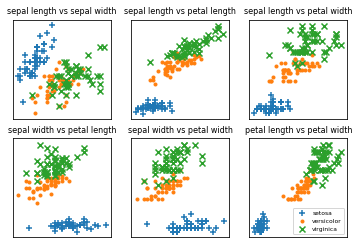

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [20]:
## now let's split them to training and test set

import random
from typing import TypeVar, List, Tuple
X = TypeVar('X')  # generic type to represent a data point

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.


random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

## Art of selecting k
The training set will be the “neighbors” that we’ll use to classify the points in the test set. We just need to choose a value for k, the number of neighbors who get to vote. Too small (think k = 1), and we let outliers have too much influence; too large (think k = 105), and we just predict the most common class in the dataset.<br>
We use a validation set to choose k!

In [29]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## The curse of Dimensionality
Points in high-dimensional spaces tend not to be close to one another at all, and k-nearest neighbor method runs in trouble because of it


In [30]:
# Generate random point
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

In [31]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

For every dimension from 1 to 100, we’ll compute 10,000 distances and use those to compute the average distance between points and the minimum distance between points in each dimension

In [32]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [00:18<00:00,  2.91it/s]


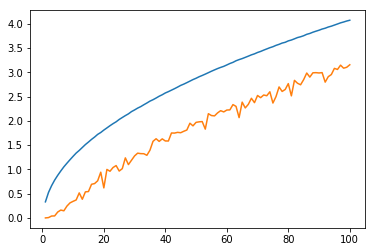

In [35]:
plt.plot(dimensions,avg_distances)
plt.plot(dimensions,min_distances)

As the number of dimensions increases, the average distance between points increases. But what’s more problematic is the ratio between the closest distance and the average distance

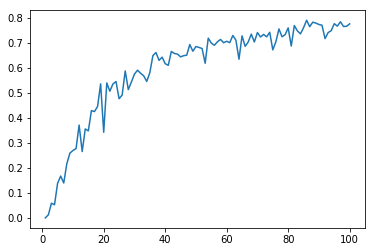

In [36]:
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]
plt.plot(dimensions,min_avg_ratio)

## if you are dealing with high dimensional data for this method, maybe you should do dimensionality reduction first.